# E6 - Bleaching Correction

This notebook focuses on the effect of **photobleaching** on SOFI cumulant reconstructions and cusp-artifacts. We show that photobleaching can introduce error in virtual brightnesses displayed in SOFI images, and a bleaching correction step can restore the true brightness.

To get familiar with cusp-artifacts, please start with our [demo 1](https://github.com/xiyuyi-at-LLNL/pysofi/blob/master/Notebooks/CuspArtifactsDemo1_3Emitters.ipynb) and [demo 2](https://github.com/xiyuyi-at-LLNL/pysofi/blob/master/Notebooks/CuspArtifactsDemo2_SlowVaryingRho.ipynb). For more explanation and condition exploration for cusp-artifacts, please refer to [this paper](https://www.osapublishing.org/boe/fulltext.cfm?uri=boe-11-2-554&id=425585). 

In this notebook, we use similar data as in [demo 2](https://github.com/xiyuyi-at-LLNL/pysofi/blob/master/Notebooks/CuspArtifactsDemo2_SlowVaryingRho.ipynb). In demo 2, there is no photobleaching for any emitter. Here we repeat the same simulation, but add in stochastic bleaching events using Poisson bleaching statistics. We first generated the simulation, and performed fourier interpolation on it (the same as [demo 1](https://github.com/xiyuyi-at-LLNL/pysofi/blob/master/Notebooks/CuspArtifactsDemo1_3Emitters.ipynb)).  

**Bleaching correction** was implemented to overcome the error in SOFI reconstructions by truncating the overall movie series into individual blocks. For more information, please refer to fig. 5 and appendix 3 of this [paper](https://www.osapublishing.org/boe/fulltext.cfm?uri=boe-11-2-554&id=425585).

In this notebook, we demonstrate how to use **pysofi** to generate average high-order SOFI images (auto-cumulants) over user-defined number of blocks, and how a bleaching correction step can retore the true brightness in SOFI images. The user can also choose to save the bleaching-corrected images into a new tiff file, and pass it to further SOFI processing steps.

In [1]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from functions import (reconstruction, filtering, pysofi)
import tifffile as tiff
%matplotlib inline
%load_ext autoreload
%autoreload 2

Loading BokehJS ...

## Plot the signal intensity change.

First, let us compare the signal intensity change for videos with and without photobleaching. The high frequency components (blue) are filtered-out using <code>filtering.med_smooth</code> to obtain a smoothed time evolution of average signal (orange). The user can tune <code>kernel_size</code> to achieve optimal filtered signal.

In [2]:
filepath = '../sampledata/simulations'
filename_bleach = 'Bleach_SlowVaryingRho_frame2000_Emi51_InterpNum8.tif'
filename_nobleach = 'SlowVaryingRho_frame2000_Emi51_InterpNum8.tif'
# Get the total signal
signal_bleach = reconstruction.calc_total_signal(filepath, filename_bleach)
signal_nobleach = reconstruction.calc_total_signal(filepath, filename_nobleach)
# Median filtering to smooth the signal
filtered_signal_bleach = filtering.med_smooth(signal_bleach, kernel_size=251)
filtered_signal_nobleach = filtering.med_smooth(signal_nobleach, kernel_size=251)

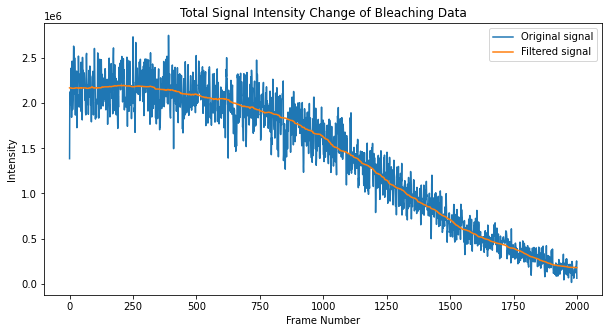

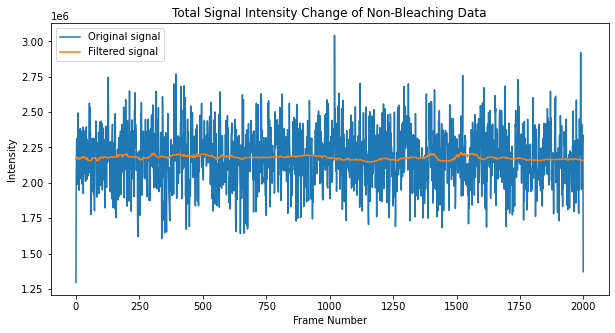

In [3]:
# Plot and compare signal changes for data with / without photobleaching
plt.figure(figsize=(10,5))
plt.plot(signal_bleach, label='Original signal')
plt.plot(filtered_signal_bleach, label='Filtered signal')
plt.xlabel('Frame Number')
plt.ylabel('Intensity')
plt.title('Total Signal Intensity Change of Bleaching Data')
plt.legend()

plt.figure(figsize=(10,5))
plt.plot(signal_nobleach, label='Original signal')
plt.plot(filtered_signal_nobleach, label='Filtered signal')
plt.xlabel('Frame Number')
plt.ylabel('Intensity')
plt.title('Total Signal Intensity Change of Non-Bleaching Data')
plt.legend()

As we can see from the plots above, if no emitter is bleached throughout the whole video, then the total signal intensity stays at a fixed value (with small oscillations), while total intensity decays with photobleaching.

## Reconstruction error from photobleaching.

Photobleaching would cause on-time-ratio $\rho$ to deviate from its estimated value. The 'bleached' state can be considered as an ultralong 'off' state, causing a decrease in $\rho$ values. Since accurate cumulant reconstructions depend on precise $\rho$ estimation, photobleaching can introduce large errors. 

Here are SOFI-reconstructed images for data with and without photobleaching. The bleaching correction is not used in this step.

In [4]:
im_bleach = pysofi.PysofiData(filepath, filename_bleach)
k_set_bleach = im_bleach.cumulants_images(highest_order=7)

im_nobleach = pysofi.PysofiData(filepath, filename_nobleach)
k_set_nobleach = im_nobleach.cumulants_images(highest_order=7)

Calculating the 1st-order moment reconstruction...
[==============================] 100.0%

Calculating the 2nd-order moment reconstruction...
[==============================] 100.0%

Calculating the 3rd-order moment reconstruction...
[==============================] 100.0%

Calculating the 4th-order moment reconstruction...
[==============================] 100.0%

Calculating the 5th-order moment reconstruction...
[==============================] 100.0%

Calculating the 6th-order moment reconstruction...
[==============================] 100.0%

Calculating the 7th-order moment reconstruction...
[==============================] 100.0%



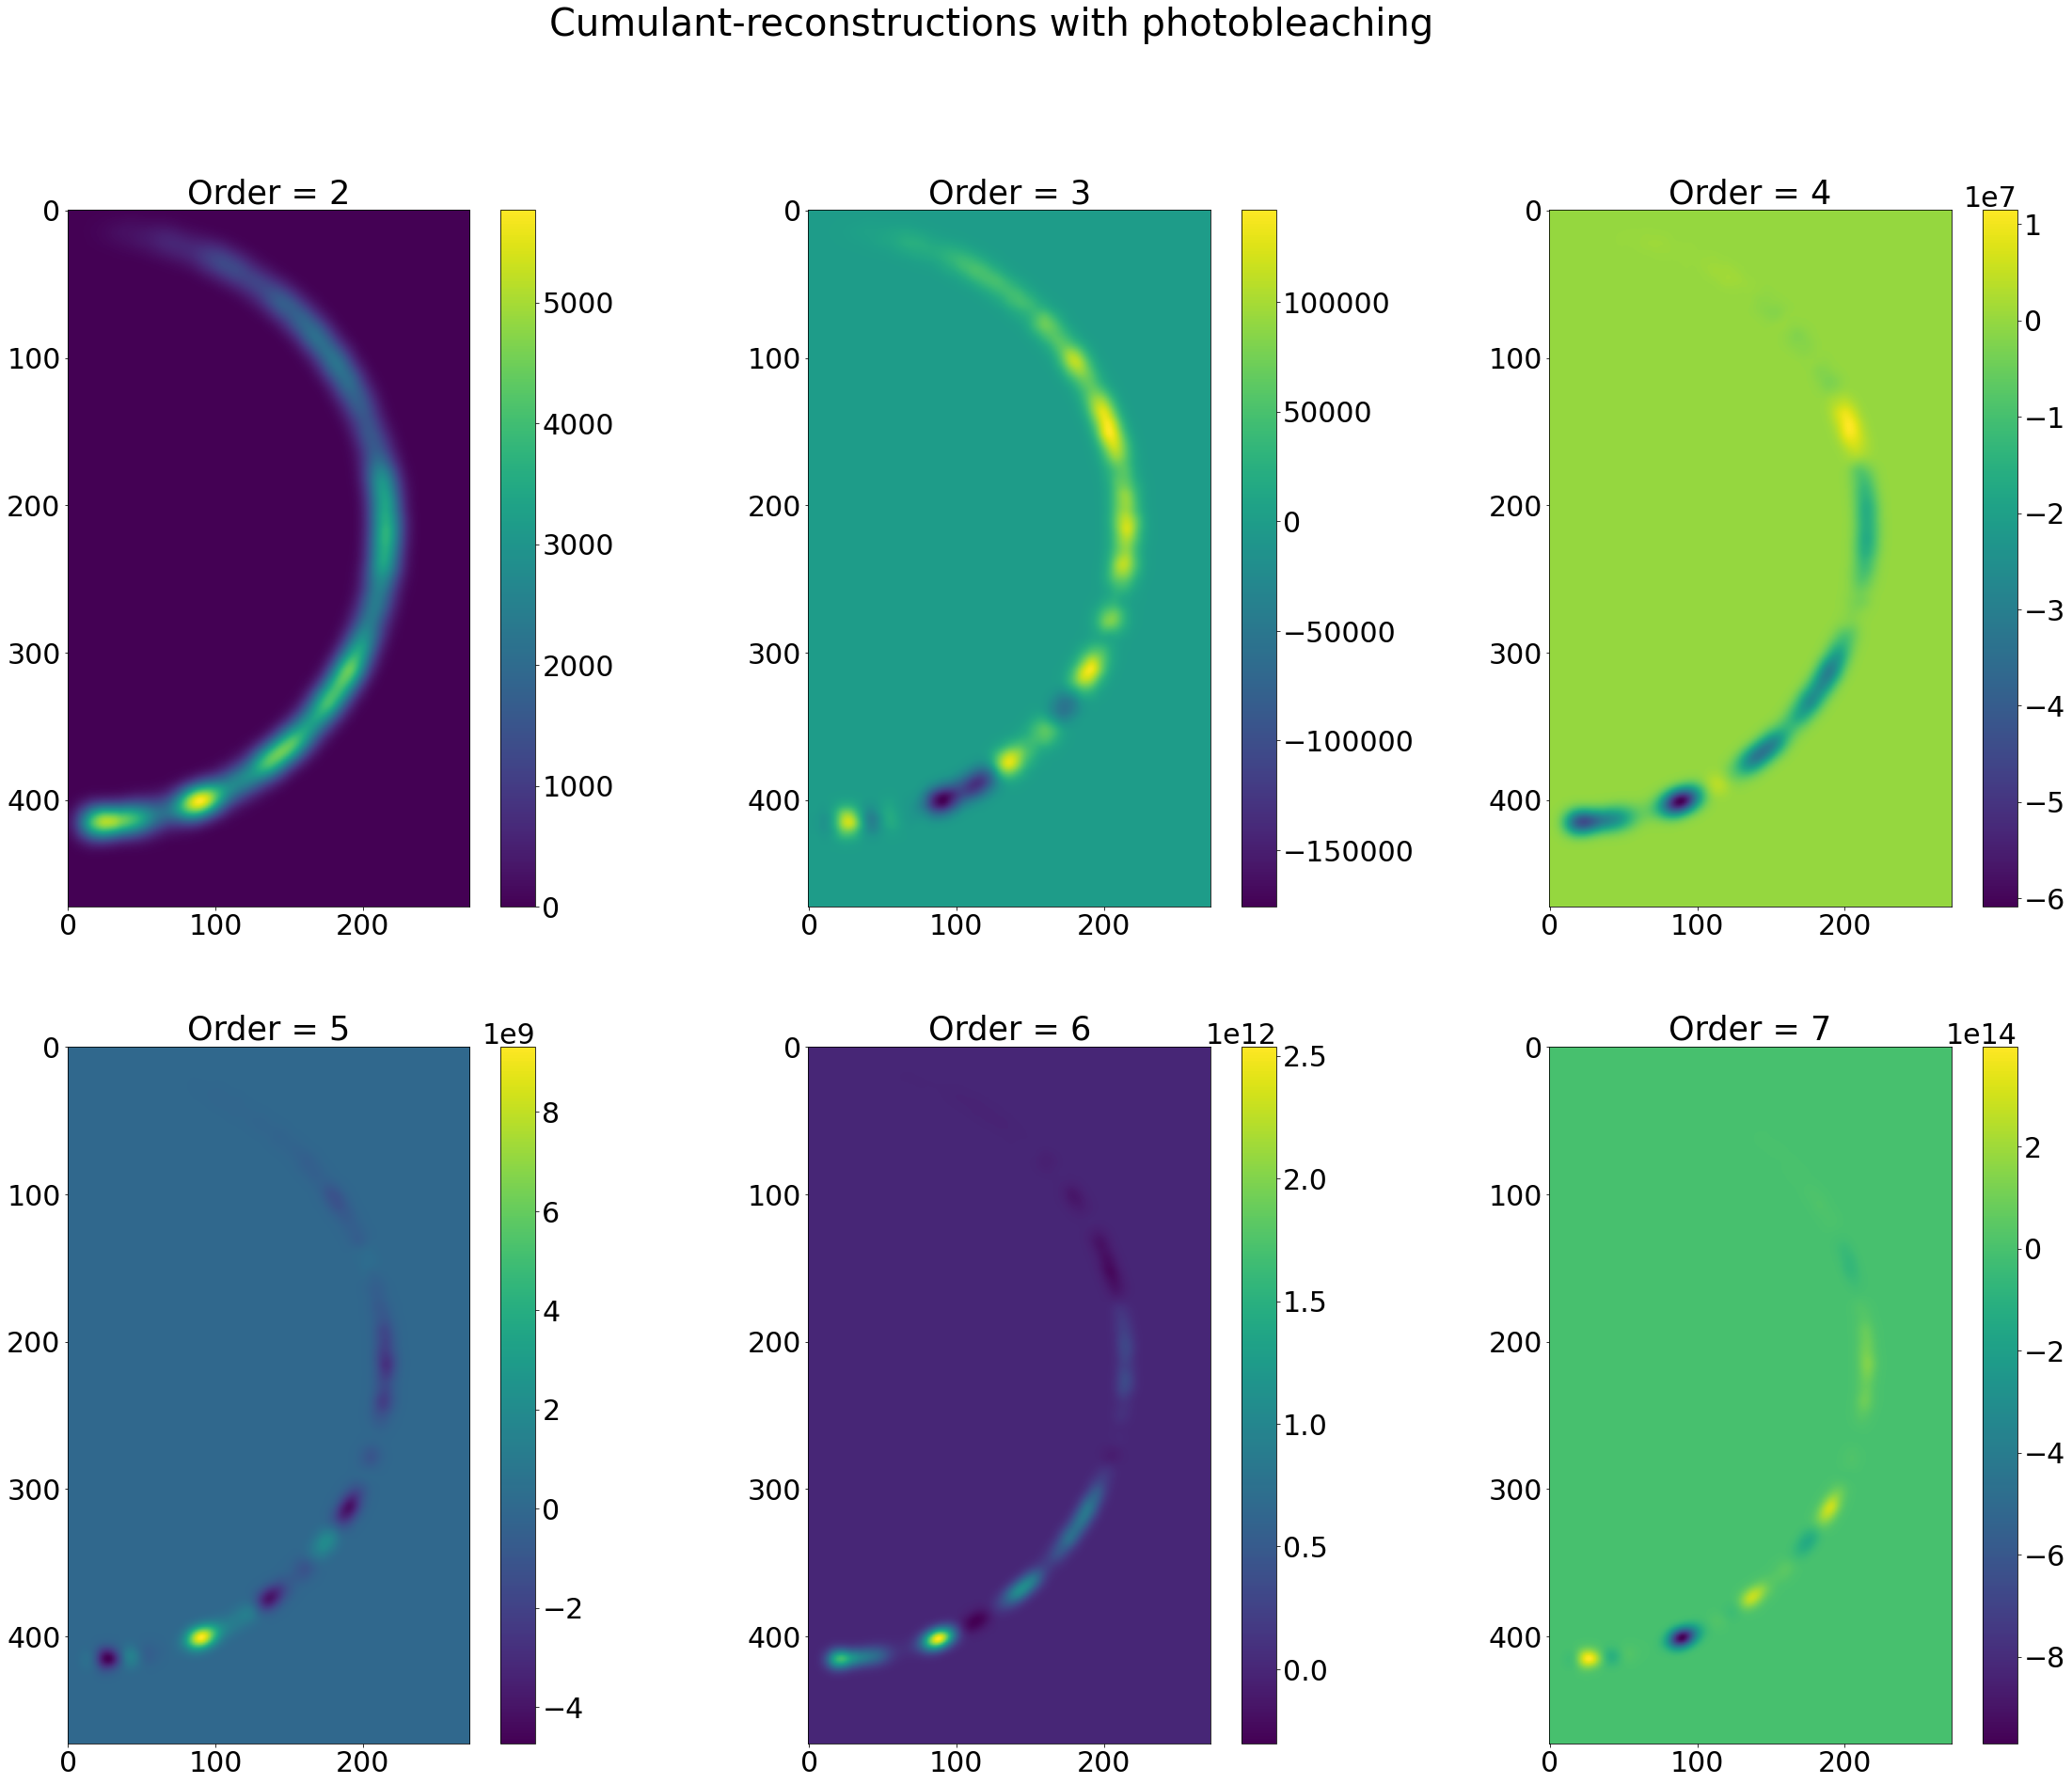

In [5]:
# Plot reconstructions for data with photobleaching
fig, axs = plt.subplots(2,3,figsize=(40,30))
fig.suptitle("Cumulant-reconstructions with photobleaching", fontsize=40)
for i in range(2,8):
    row = (i - 2) // 3
    ax = axs[row,i-2-row*3]
    img = ax.imshow(k_set_bleach[i]*0.8)
    ax.tick_params(axis='x', labelsize= 30)
    ax.tick_params(axis='y', labelsize= 30)
    ax.set_title(f'Order = {i}', fontsize=35)
    cb = plt.colorbar(img, ax=ax)
    cb.ax.tick_params(labelsize=30)
    cb.ax.yaxis.get_offset_text().set_fontsize(30)

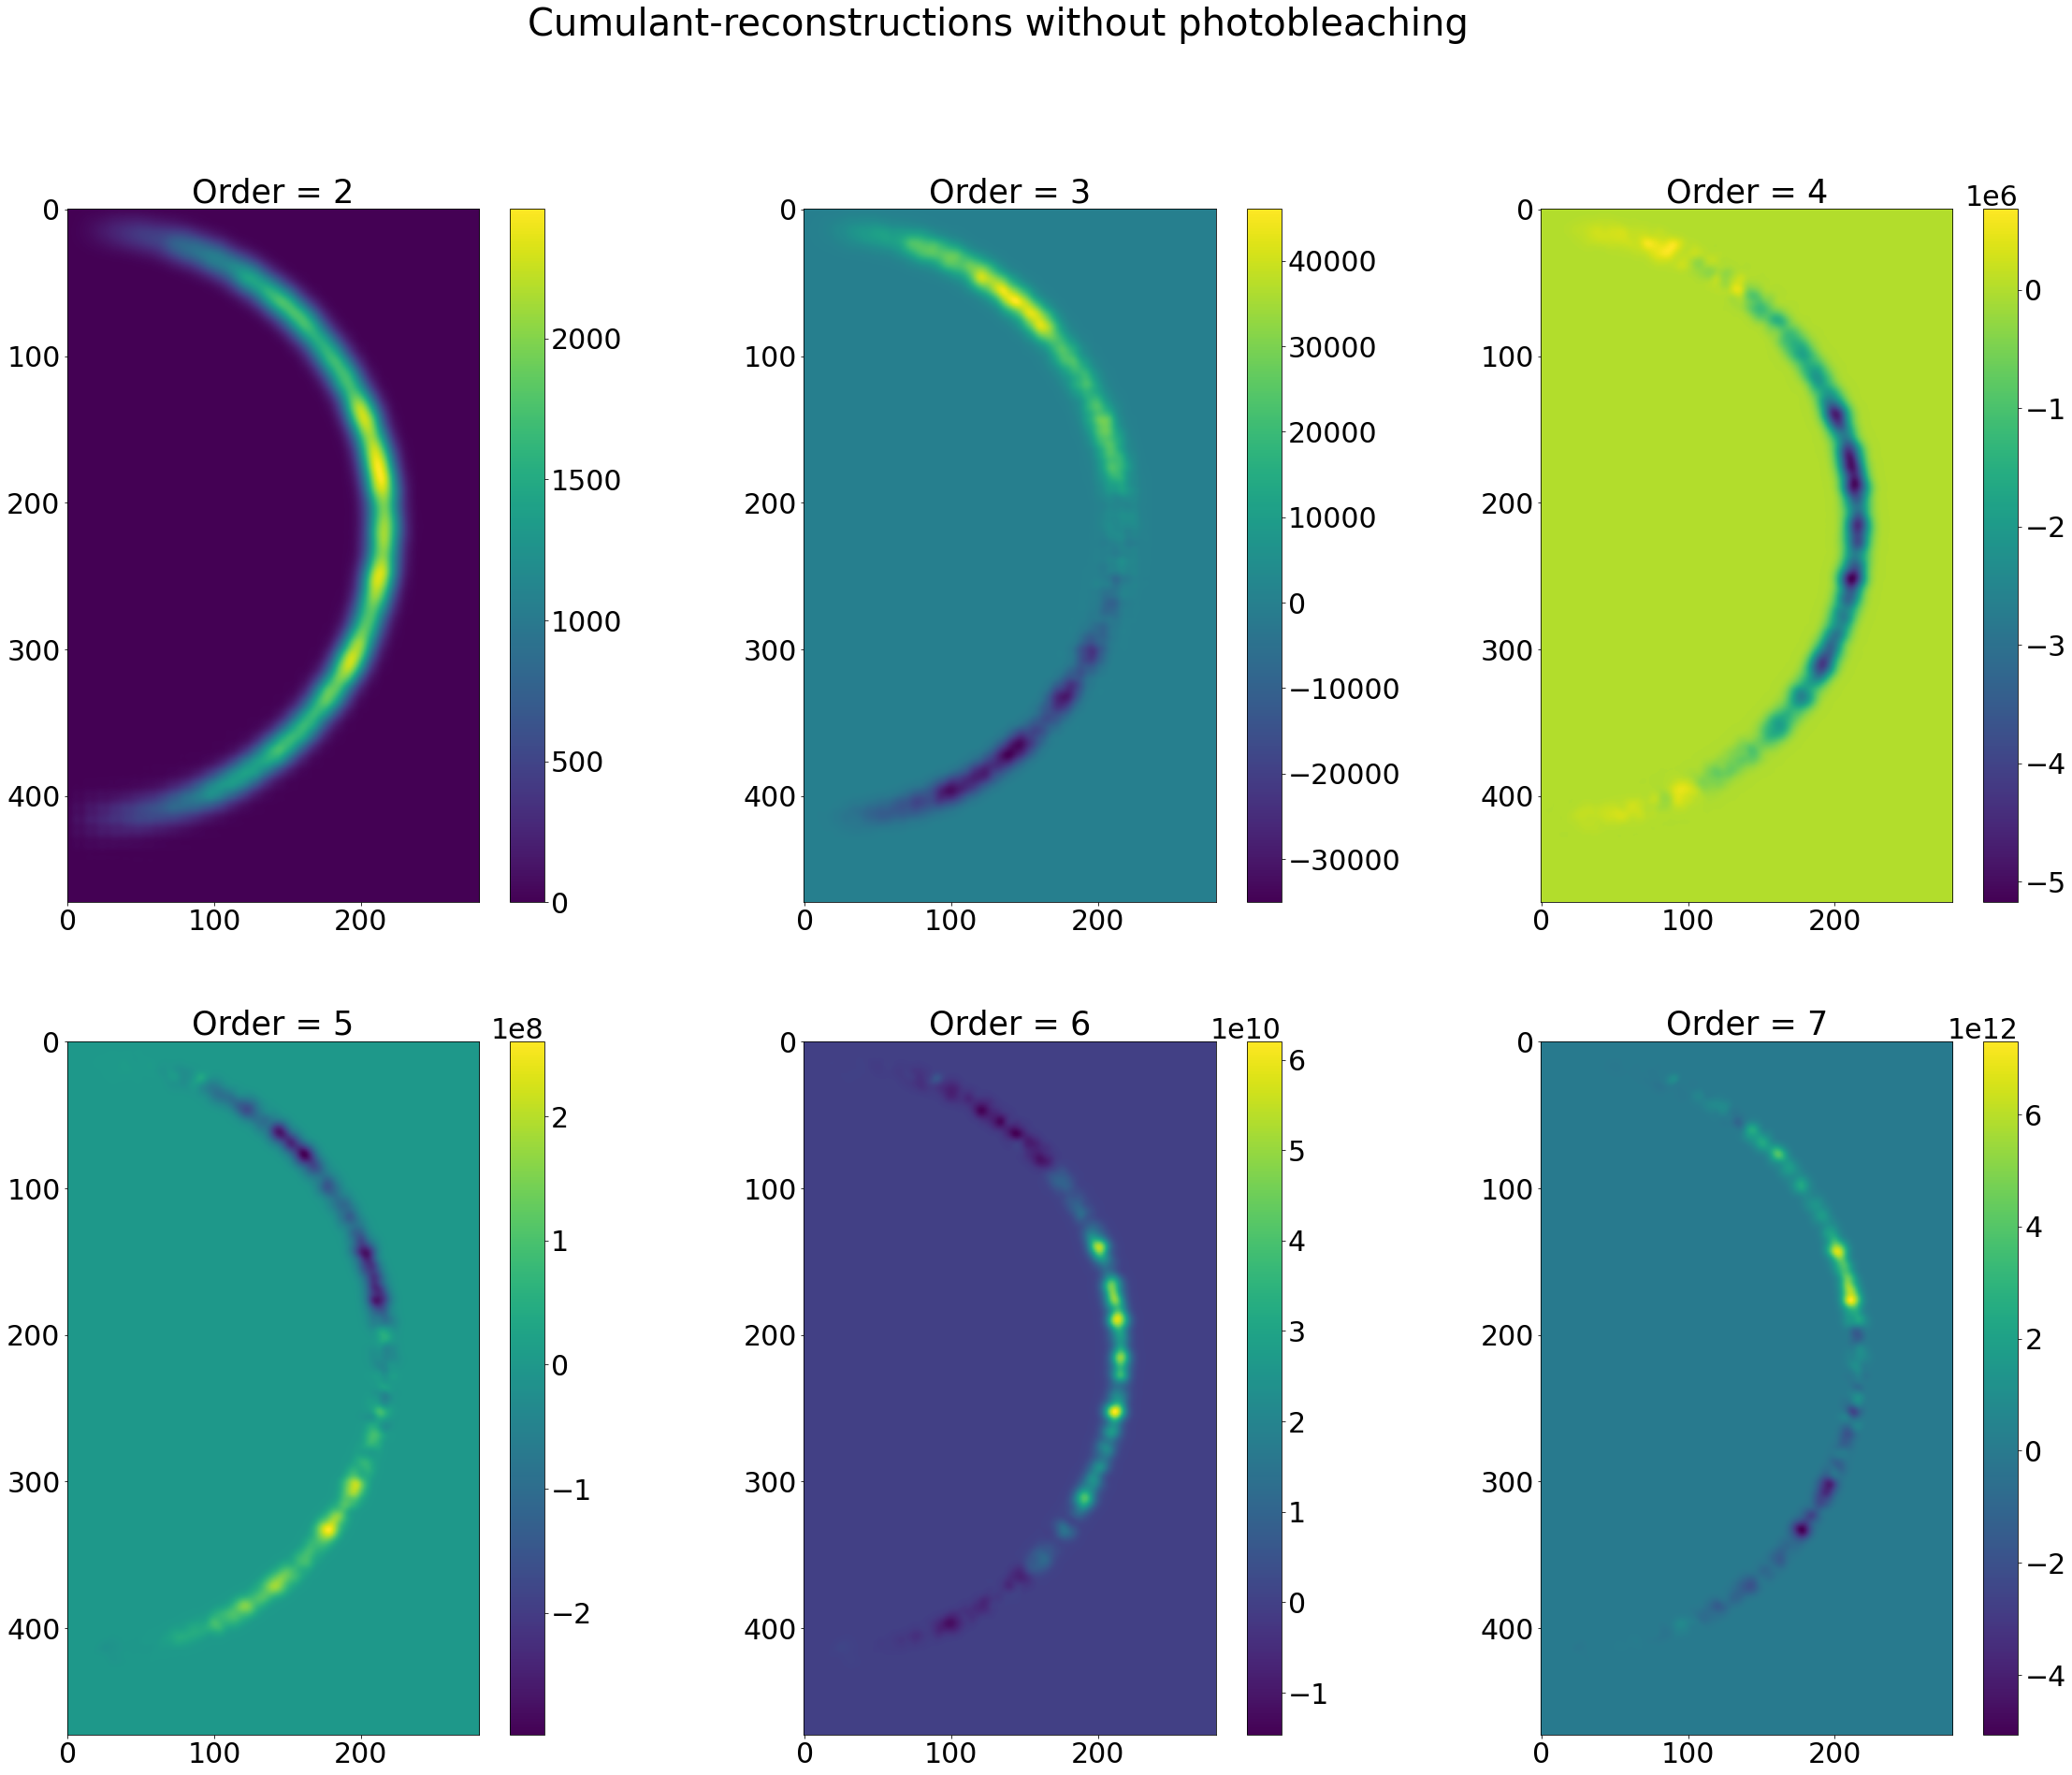

In [19]:
# Plot reconstructions for data without photobleaching
fig, axs = plt.subplots(2,3,figsize=(40,30))
fig.suptitle("Cumulant-reconstructions without photobleaching", fontsize=40)
for i in range(2,8):
    row = (i - 2) // 3
    ax = axs[row,i-2-row*3]
    img = ax.imshow(k_set_nobleach[i]*0.8)
    ax.tick_params(axis='x', labelsize= 30)
    ax.tick_params(axis='y', labelsize= 30)
    ax.set_title(f'Order = {i}', fontsize=35)
    cb = plt.colorbar(img, ax=ax)
    cb.ax.tick_params(labelsize=30)
    cb.ax.yaxis.get_offset_text().set_fontsize(30)

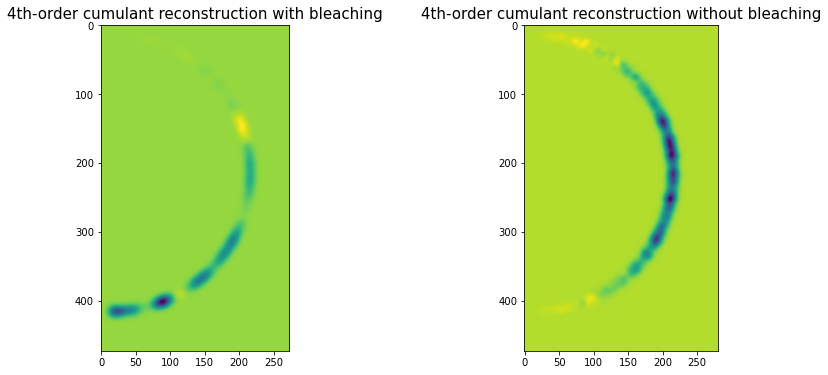

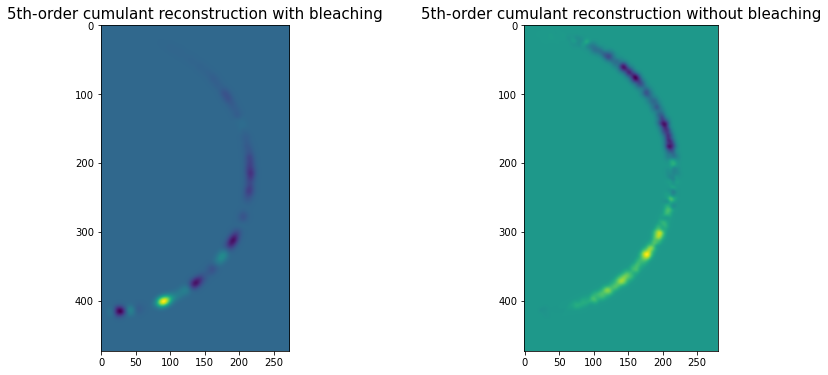

In [57]:
# Compare reconstructions of the same order
fig, axs = plt.subplots(ncols=2, figsize=(14, 6))
axs[0].set_title('4th-order cumulant reconstruction with bleaching', fontsize=15)
axs[0].imshow(k_set_bleach[4])
axs[1].set_title('4th-order cumulant reconstruction without bleaching',fontsize=15)
axs[1].imshow(k_set_nobleach[4])

fig, axs = plt.subplots(ncols=2, figsize=(14, 6))
axs[0].set_title('5th-order cumulant reconstruction with bleaching', fontsize=15)
axs[0].imshow(k_set_bleach[5])
axs[1].set_title('5th-order cumulant reconstruction without bleaching',fontsize=15)
axs[1].imshow(k_set_nobleach[5])
plt.show()

## Bleaching-corrected moment/cumulant reconstruction.

We can clearly see from the comparison above that, for photobleaching data, the signs of the virtual brightnesses displayed in the SOFI images deviate from those predicted. 

To over come this problem, we implement a bleaching correction step by breaking up the whole video into small blocks and calculating the average cumulants over all blocks. Within each block, the amount of signal decrease is identical. This amount of signal decrease is characterized by the bleaching correction factor, **fbc**, which is the fractional signal decrease within each block (as compared to the total signal decrease over the whole signal plot). The user can tune the fbc value in <code>d.cumulants_images</code>. Here we compare the results of <code>fbc=0.1, 0.05, 0.04, 0.01</code>.

For more information on the bleaching correction method and trade-offs between fbc value and statistical significance, please refer to fig. 5 and appendix 3 of this [paper](https://www.biorxiv.org/content/10.1101/545574v2.full.pdf). The user can (1) implement the <code>bleach_correction</code> option when calculating moment/cumulant reconstructions, or (2) save the bleaching-corrected image stacks in a new tiff file for further SOFI analysis. Below we will first show option (1).

In [58]:
# SOFI-process photobleaching data with bleaching correction (fbc=0.04)
k_set_bc = im_bleach.cumulants_images(highest_order=7, bleach_correction=True,
                                          smooth_kernel=251, fbc=0.04)

Calculating moments of block 0...
[==============================] 100.0%

Calculating moments of block 1...
[==============================] 100.0%

Calculating moments of block 2...
[==============================] 100.0%

Calculating moments of block 3...
[==============================] 100.0%

Calculating moments of block 4...
[==============================] 100.0%

Calculating moments of block 5...
[==============================] 100.0%

Calculating moments of block 6...
[==============================] 100.0%

Calculating moments of block 7...
[==============================] 100.0%

Calculating moments of block 8...
[==============================] 100.0%

Calculating moments of block 9...
[==============================] 100.0%

Calculating moments of block 10...
[==============================] 100.0%

Calculating moments of block 11...
[==============================] 100.0%

Calculating moments of block 12...
[==============================] 100.0%

Calculating moments of

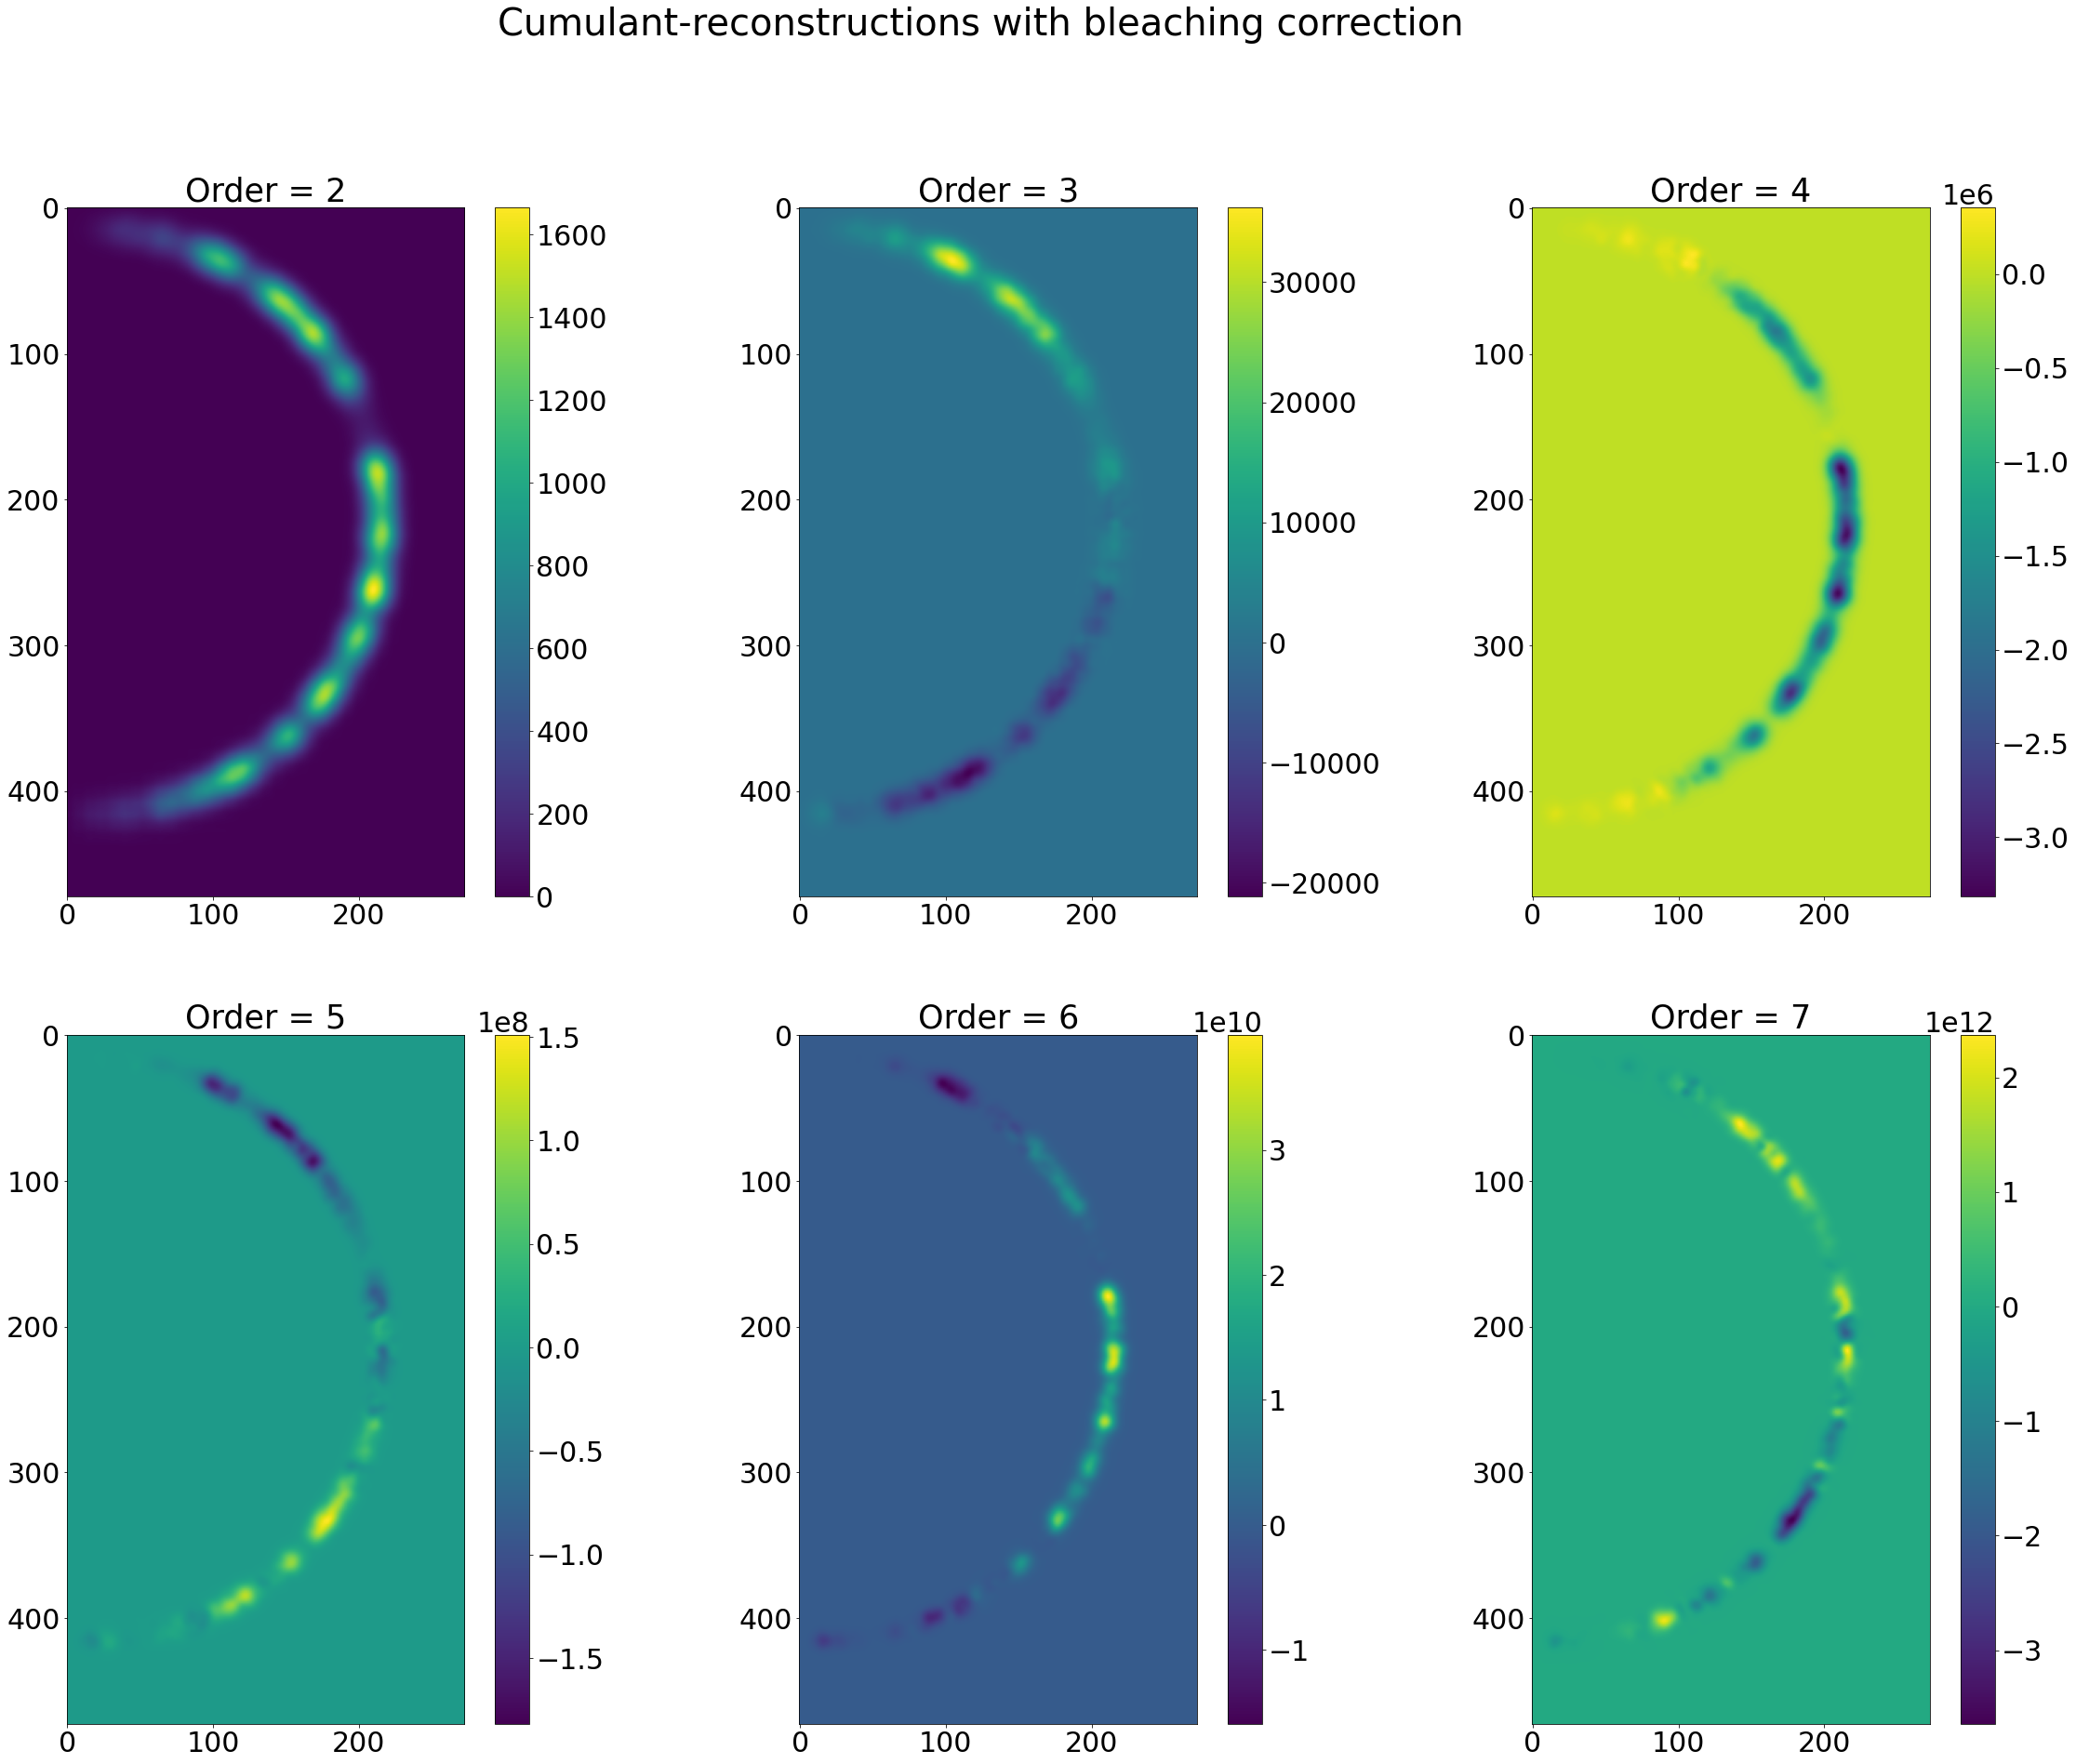

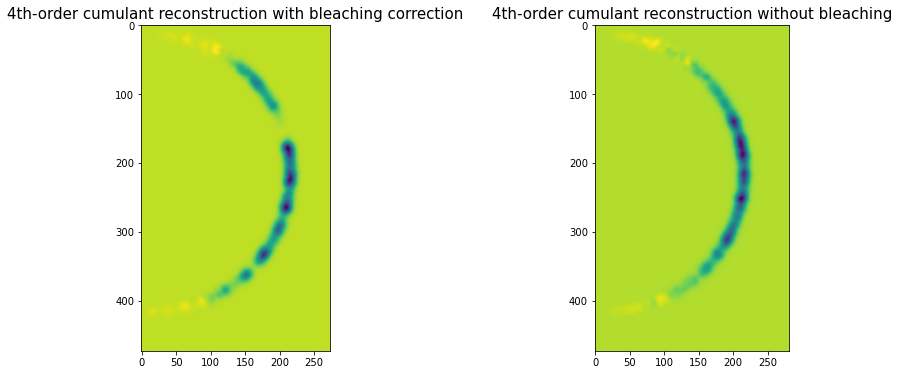

In [63]:
# Plot the result and compare with non-photobleaching data
fig, axs = plt.subplots(2,3,figsize=(40,30))
fig.suptitle("Cumulant-reconstructions with bleaching correction", fontsize=40)
for i in range(2,8):
    row = (i - 2) // 3
    ax = axs[row,i-2-row*3]
    img = ax.imshow(k_set_bc[i]*0.8)
    ax.tick_params(axis='x', labelsize= 30)
    ax.tick_params(axis='y', labelsize= 30)
    ax.set_title(f'Order = {i}', fontsize=35)
    cb = plt.colorbar(img, ax=ax)
    cb.ax.tick_params(labelsize=30)
    cb.ax.yaxis.get_offset_text().set_fontsize(30)
    
fig, axs = plt.subplots(ncols=2, figsize=(15, 6))
axs[0].set_title('4th-order cumulant reconstruction with bleaching correction', fontsize=15)
axs[0].imshow(k_set_bc[4])
axs[1].set_title('4th-order cumulant reconstruction without bleaching',fontsize=15)
axs[1].imshow(k_set_nobleach[4])

As we can see above, with the help of bleaching correction, the virtual brightness distribution are recovered to the case without bleaching that agrees with the prediction based on blinking statistics when sufficient statistical significance is provided.

## Save bleaching-corrected image stack.

Besides calculating the bleaching-corrected moment/culumant reconstructions directly, another option for the user to implement bleaching correction in the analysis pipeline is to save the corrected images in a new tiff file. The new file new then be passed to SOFI2.0 pipeline or any other analysis methods that benefit from the bleaching correction. The user can also choose to return all the corrected images in a 3d array by setting <code>return_option=True</code>. However, we recommend saving the file if the length of the original data is big.

In [ ]:
im_bleach.bleach_correct(fbc=0.04, smooth_kernel=251, save_option=True, return_option=False)

## Play with <code>fbc</code> value

Here we set <code>fbc=0.04</code>, meaning that the whole video are broken up into 25 blocks, and in each block the signal intensity decreases 4% of the total intensity drop. We also try <code>fbc=0.1, 0.05, 0.01</code> and compare the difference.

In [59]:
k_set_bc2 = im_bleach.cumulants_images(highest_order=7, bleach_correction=True,
                                          smooth_kernel=251, fbc=0.1)

Calculating moments of block 0...
[==============================] 100.0%

Calculating moments of block 1...
[==============================] 100.0%

Calculating moments of block 2...
[==============================] 100.0%

Calculating moments of block 3...
[==============================] 100.0%

Calculating moments of block 4...
[==============================] 100.0%

Calculating moments of block 5...
[==============================] 100.0%

Calculating moments of block 6...
[==============================] 100.0%

Calculating moments of block 7...
[==============================] 100.0%

Calculating moments of block 8...
[==============================] 100.0%

Calculating moments of block 9...
[==============================] 100.0%



In [60]:
k_set_bc3 = im_bleach.cumulants_images(highest_order=7, bleach_correction=True,
                                          smooth_kernel=251, fbc=0.05)

Calculating moments of block 0...
[==============================] 100.0%

Calculating moments of block 1...
[==============================] 100.0%

Calculating moments of block 2...
[==============================] 100.0%

Calculating moments of block 3...
[==============================] 100.0%

Calculating moments of block 4...
[==============================] 100.0%

Calculating moments of block 5...
[==============================] 100.0%

Calculating moments of block 6...
[==============================] 100.0%

Calculating moments of block 7...
[==============================] 100.0%

Calculating moments of block 8...
[==============================] 100.0%

Calculating moments of block 9...
[==============================] 100.0%

Calculating moments of block 10...
[==============================] 100.0%

Calculating moments of block 11...
[==============================] 100.0%

Calculating moments of block 12...
[==============================] 100.0%

Calculating moments of

In [61]:
k_set_bc4 = im_bleach.cumulants_images(highest_order=7, bleach_correction=True,
                                          smooth_kernel=251, fbc=0.01)

Calculating moments of block 0...
[==============================] 100.0%

Calculating moments of block 1...
[==============================] 100.0%

Calculating moments of block 2...
[==============================] 100.0%

Calculating moments of block 3...
[==============================] 100.0%

Calculating moments of block 4...
[==============================] 100.0%

Calculating moments of block 5...
[==============================] 100.0%

Calculating moments of block 6...
[==============================] 100.0%

Calculating moments of block 7...
[==============================] 100.0%

Calculating moments of block 8...
[==============================] 100.0%

Calculating moments of block 9...
[==============================] 100.0%

Calculating moments of block 10...
[==============================] 100.0%

Calculating moments of block 11...
[==============================] 100.0%

Calculating moments of block 12...
[==============================] 100.0%

Calculating moments of

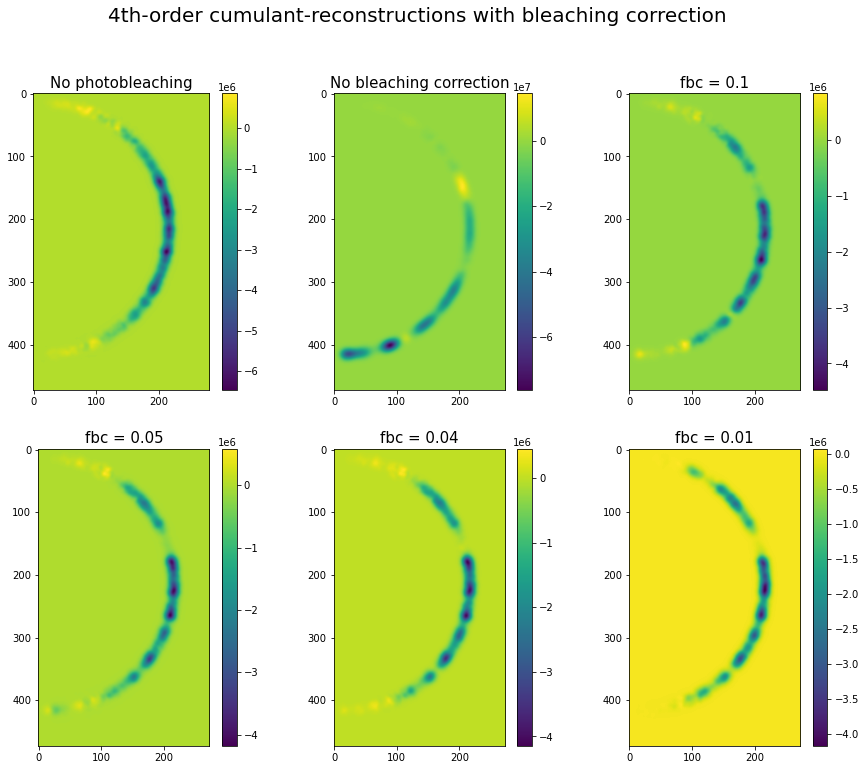

In [79]:
# Compare the 4th-order reconstruction for different fbc values
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 12))
fig.suptitle("4th-order cumulant-reconstructions with bleaching correction", fontsize=20)
axs[0,0].set_title('No photobleaching',fontsize=15)
im = axs[0,0].imshow(k_set_nobleach[4])
fig.colorbar(im, ax=axs[0,0])
axs[0,1].set_title('No bleaching correction', fontsize=15)
im = axs[0,1].imshow(k_set_bleach[4])
fig.colorbar(im, ax=axs[0,1])
axs[0,2].set_title('fbc = 0.1', fontsize=15)
im = axs[0,2].imshow(k_set_bc2[4])
fig.colorbar(im, ax=axs[0,2])
axs[1,0].set_title('fbc = 0.05', fontsize=15)
im = axs[1,0].imshow(k_set_bc3[4])
fig.colorbar(im, ax=axs[1,0])
axs[1,1].set_title('fbc = 0.04', fontsize=15)
im = axs[1,1].imshow(k_set_bc[4])
fig.colorbar(im, ax=axs[1,1])
axs[1,2].set_title('fbc = 0.01', fontsize=15)
im = axs[1,2].imshow(k_set_bc4[4])
fig.colorbar(im, ax=axs[1,2])

With bleaching correction, the virtual brightness and the feature of the cusp-artifacts are restored and becomes similar with the case without bleaching. Such restoration is not quite sensitive to the choice of fbc, but we think <code>fbc=0.04</code> yields the results closest to the non-photobleaching case. We encourage users to try different fbc values for their own application cases.

Here, we would like to highlight the trade-offs between the bleaching correction factor (fbc) and statistical significance of the blinking trajectories. When fbc gets smaller, the total number of bleaching events occurring within each block decreases. Thus, a smaller fbc reduces the statistical significance of the blinking trajectories within each block and increases the total number of blocks for constructing the final cumulant. FOr more information, please refer to this [paper](https://www.biorxiv.org/content/10.1101/545574v2.full.pdf).